In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Preparing the data

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/nihargajre/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path / 'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [7]:
data_lm.save()

In [8]:
data = TextDataBunch.load(path)

## Tokenization

In [11]:
data = TextDataBunch.load(path)
data.learner_type

<bound method DataBunch.learner_type of <fastai.text.data.TextDataBunch object at 0x7fbedbffbcf8>>

In [14]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

In [16]:
data.train_ds[0][0][:10]

[20, 42, 35, 173, 63, 6, 351, 3, 47, 1493]

In [17]:
data = (TextSplitData.from_csv(path, 'texts.csv', input_cols=1, label_cols=0, valid_col=2)
           .datasets(TextDataset)
           .tokenize()
           .numericalize()
           .databunch(TextDataBunch))

In [3]:
path = untar_data(URLs.IMDB)

In [4]:
path.ls()

[PosixPath('/home/nihargajre/.fastai/data/imdb/test'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/train'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/README'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/models')]

In [5]:
(path / 'train').ls()

[PosixPath('/home/nihargajre/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/train/pos'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/train/neg'),
 PosixPath('/home/nihargajre/.fastai/data/imdb/train/unsup')]

In [21]:
data_lm = (TextFileList.from_folder(path)
          .label_const(0)
          .split_by_folder(valid='test')
          .datasets()
          .tokenize()
          .numericalize()
          .databunch(TextLMDataBunch))

data_lm.save('tmp_lm')

In [6]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm')
data_lm.show_batch()

idx,text
0,"xxfld 1 my wife and i saw this film yesterday and i thought that it was a pretty good movie . of course , my motivation to see it was to get a look at roselyn sanchez and sofia vergara . i figured that my wife could have equal eye candy with the main actor who played xxunk . it is interesting to note that this movie was directed by a latina , and of course featured a great many latinos in the movie , with very few other ethnic actors . while i am"
1,"was alice , you could literally feel the stress she 's under for having to negotiate between the writer and the network guys , always pretending it 's not all that bad and everything is hunky - dory . \n\n the story line seemed to go nowhere . from the beginning i expected the things to happen that did happen , but i kept waiting for a twist , a punchline , xxup something . no need to say , it did not come . \n\n what really bugged me , though : i did"
2,"dramatic . they went from acknowledging the drug in the previous episode and with no backstory or character development , they simply demolished the creator and sole pusher of the drug before the opening credits finished rolling on the next episode . \n\n pa . xxup the . xxup tic . \n\n let 's face it , this series was about a morally confused and charismatic vampire with perky tits who was great at throwing the look of worry and confusion around a lot so that she could suck in the buffy and angel fans"
3,"and hollow movie . \n\n woodcock is a teacher , whose teaching style borders on child abuse you see him picking on the small kids , the fat kids and other less than athletic kids . \n\n which is fine by me , child abuse is a good subject for a serious movie . bullshit author and victim returns home and learns things about him self and makes teacher see the error of his ways sounds like a good serious movie . \n\n turn the child abuse into ' tough but fair teaching ' and"
4,"his one face expression ) , the characters have turned into something very weird ( valjean is in love with cosette ? ! ' xxunk sleeps with marius ? ! cosette turns into a spoiled brat who wants to dance ? ! i 'm sure that hugo is turning in his grave ... ) , the whole thing is full of plot holes ( gavroche never ages , the thenardiers wearing nice cloths , javert hears the "" vive la republic "" and does nothing ) and why the hell is gavroche marius ' best"
5,"go dancers in cages is to unveil a card that indicates how much the question is worth . a correct answer adds the card 's dollar figure to the contestant 's running total ; a wrong answer subtracts the same sum . this time - consuming step actually has some entertainment value , as it allows the audience to get a close look at the scantily clad and uniformly gorgeous dancers . meanwhile , the contestant is reminded that an unlucky selection of the "" killer card "" will end the game instantly . this"
6,"as a brute with no class . charles was a scot but there was not even the faintest hint of a scottish accent here , and only the clumsiest inclusion of badly performed stutters . he had clearly not done his homework . i guess alec guinness set a standard for this part ( in ' cromwell ' ) which may be impossible to surpass . but the difference is that guinness was a good actor . \n\n dougray scott played fairfax better , but it just got tiresome . \n\n as for the script"
7,"by the way , was not very successful when miriam hopkins and tallulah bankhead appeared in it . \n\n this is a film to be treasured thanks to william wyler . xxfld 1 it 's been nothing but trouble lately , for the two managers of the lotus cat food co. the gravedigger who 's been supplying them with their food 's main ingredient -- freshly xxunk human cadavers -- has been pestering them for monies due , and a suspicious doctor and his hotty blond nurse have taken to snooping around the premises ,"
8,"a tragedy that neither pitt nor lewis were nominated for any awards for their performances here . \n\n david duchovony and mi

In [7]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

In [24]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


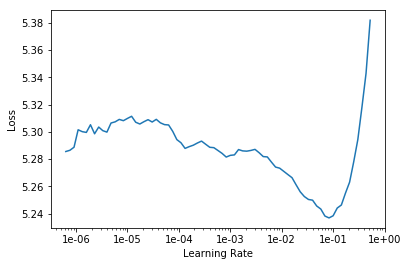

In [26]:
learn.recorder.plot(skip_end=15)

In [27]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

Total time: 17:24
epoch  train_loss  valid_loss  accuracy
1      4.605833    4.441372    0.250586  (17:24)



In [28]:
learn.save('fit-head')

In [8]:
## Do this and continue
learn.load('fit-head');

In [9]:
learn.unfreeze()

In [10]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

Total time: 3:14:27
epoch  train_loss  valid_loss  accuracy
1      4.336276    4.273323    0.268034  (19:31)
2      4.240357    4.192965    0.278009  (19:24)
3      4.210788    4.147759    0.283587  (19:26)
4      4.138242    4.108101    0.288167  (19:24)
5      4.075981    4.079360    0.291761  (19:26)
6      3.985066    4.059000    0.293951  (19:26)
7      3.939491    4.041905    0.296084  (19:27)
8      3.891072    4.033793    0.297374  (19:24)
9      3.851571    4.030103    0.297811  (19:30)
10     3.824062    4.030593    0.297811  (19:25)



In [11]:
learn.save('fine-tuned')

In [12]:
learn.save_encoder('fine_tuned_enc')

In [13]:
data_clas = (TextFileList.from_folder(path)
             #grap all the text files in path
            .label_from_folder(classes=['neg','pos'])
             #label them all with their folder, only keep 'neg' and 'pos'
            .split_by_folder(valid='test')
             #split by folder between train and validation set
            .datasets()
             #use `TextDataset`, the flag `is_fnames=True` indicates to read the content of the files passed
            .tokenize()
             #tokenize with defaults from fastai
            .numericalize(vocab = data_lm.vocab)
             #numericalize with the same vocabulary as our pretrained model
            .databunch(TextClasDataBunch, bs=50))
data_clas.save('tmp_clas')

In [14]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both opponents have to go through tables in order to get the win . benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray . a german suplex by benoit to bubba took the wind out of the dudley brother . spike tried to",pos
"xxfld 1 some have praised _ xxunk _ as a disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . the "" crack staff "" of many older adventure movies has been done well before , ( think _ the dirty dozen _ ) but _ atlantis _ represents one of the worse films in that motif . the characters are weak .",neg
"xxfld 1 pier paolo pasolini , or pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated european marxist director - and they are thick on the ground . how anyone can see "" art "" in this messy , cheap sex - romp concoction is beyond me . some of the "" stories "" here could have come straight out of a soft - core porn film , and i am not even so much referring to the nudity but the",neg
"xxfld 1 streisand fans only familiar with her work from the xxup funny xxup girl film onwards need to see this show to see what a brilliant performer streisand xxup was - xxup before she achieved her goal of becoming a movie star . there had never been a female singer quite like her ever before , and there never would be again ( sorry , celine - only in your dreams ! ) , but never again would streisand sing with the vibrancy , energy , and , above all , the xxup enthusiasm and xxup vulnerability with which",pos
"xxfld 1 it is not as great a film as many people believe ( including my late aunt , who said it was her favorite movie ) . but due to the better sections of this film noir , particularly that justifiably famous "" fun house "" finale , xxup the xxup lady xxup from xxup shanghai has gained a position of importance beyond it 's actual worth as a key to the saga of orson welles ' failure to conquer hollywood . \n\n by 1946 welles ' position as a hollywood figure was mixed . xxup citizen xxup kane",pos
"xxfld 1 around the late 1970 's , animator don bluth , frustrated with the output his company , disney was churning , defected from the mouse house to form his own studio . his first production , xxup the xxup secret of xxup nimh , was a brilliant feature that still holds up well to this day . this was followed by an american xxup tail and xxup the xxup land xxup before xxup time , both of which were made under the involvement of steven spielberg and were commercially successful . although none of those two films had",neg
"xxfld 1 retitled from its original japanese name of xxup laputa ( for being an offensive phrase , something which director hayao miyazaki was oblivious to at the time ) , xxup castle in xxup the xxup sky is the master animator 's third film , and it 's one of his most beloved of all time . initially a box office disappointment in its 1986 release , it has since been embraced by critics and audiences around the world . inspired by jonathan swift 's "" gulliver 's travels "" , xxup castle in xxup the xxup sky is",pos
"xxfld 1 to sum this documentary up in a few words is next to impossible . every fiber of your body tells you that this is not happening right from the opening montage of rapid - fire images , through to the last shot of the clean up at ground zero , but every frame is real . the story was thought up by two french brothers living in new york . jules ( 28 ) and gideon ( 31 ) naudet ( pronounced "" xxunk - day "" ) want to make a documentary on new york cit

In [15]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [16]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


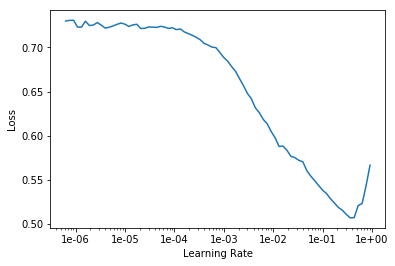

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 03:22
epoch  train_loss  valid_loss  accuracy
1      0.274738    0.223169    0.910640  (03:22)



In [19]:
learn.save('first')

In [20]:
learn.load('first')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7f2059ec1c88>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [21]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:45
epoch  train_loss  valid_loss  accuracy
1      0.282099    0.192855    0.927360  (03:45)



In [22]:
learn.save('second')
learn.load('second')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7f2059ec1c88>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:57
epoch  train_loss  valid_loss  accuracy
1      0.214847    0.171951    0.935800  (04:57)



In [24]:
learn.save('third')

In [25]:
learn.load('third')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7f2059ec1c88>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 11:55
epoch  train_loss  valid_loss  accuracy
1      0.216695    0.167848    0.937080  (05:58)
2      0.185391    0.164102    0.938640  (05:57)



In [27]:
learn.save('final')